In [ ]:
# Mount the Drive to access Data

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # Drive Access

%cd /content/drive/MyDrive/Evida_NLP_Project/

/content/drive/MyDrive/Evida_NLP_Project


# 1. Data Preprocessing


---



```
In this part we are going to prepare the data for our model.
```



In [ ]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data 

'''
In this cell we have to load the data what we are going to use.
- data : the 12 colon cancer documents and their summaries
- fifity_documents : the fifity documents no colon cancer.
In the  first experimentation, we have to use distilBErt based pretrained model. 
'''

# load the data from the excel file and choose the sheet 'ColonCancer_documents'.
data = pd.read_excel('document_data.xlsx','ColonCancer_documents')

fifity_document = pd.read_excel('fifity_document.xlsx')

In [ ]:
'''
Because of a few nomber of data for the colon cancer documents, 
we have to select 12 documents no colon cancer for this task 
in total we would have 24 documents both colon cancer and no colon cancer. 
'''
data_sel = fifity_document.iloc[0:12,:]  # We select only 12 no colon cancer documents among 50 for our task
data_selected = data_sel[['text','label','label_name']] # select the orginal text in each document , the label and label name for the no colon cancer documents

data_selected_summary = data_sel[['summary','label','label_name']] # select the orginal text in each document , the label and label name for the no colon cancer documents
data_selected['label']= 1 # Change the label value for the no colon cancer documents 
data_selected_summary['label']= 1 # Change the label value for the no colon cancer documents 
data_selected['label_name']= 'no_colonCancer' # change the labal name for the no colon cancer documents
data_selected_summary['label_name']= 'no_colonCancer' # change the labal name for the no colon cancer documents
colon_cancer_doc = data[['text','label','label_name']] # Select the orginal text in each document , the label and label name for  the colon cancer documents
colon_cancer_doc_summary = data[['summary','label','label_name']] # Select the orginal text in each document , the label and label name for  the colon cancer documents

In [ ]:
# check the shape of the data set.
print(f'fifity_document shape: {data_selected.shape}')
print(f'colon_cancer_doc shape: {colon_cancer_doc.shape}')
# check the shape of the summaries data set.
print(f'fifity_summaries_document shape: {data_selected_summary.shape}')
print(f'colon_cancer_summaries_doc shape: {colon_cancer_doc_summary.shape}')

fifity_document shape: (12, 3)
colon_cancer_doc shape: (12, 3)
fifity_summaries_document shape: (12, 3)
colon_cancer_summaries_doc shape: (12, 3)


In [ ]:
# Concatenate the colon cancer dataFrame et no colon cancer dataFrame 
all_data = pd.concat([data_selected,colon_cancer_doc])
all_data_summary = pd.concat([data_selected_summary,colon_cancer_doc_summary])
print(f'All_data  shape: {all_data.shape}') 
print(f'all_data_summary  shape: {all_data_summary.shape}') 

All_data  shape: (24, 3)
all_data_summary  shape: (24, 3)


In [ ]:
# Install and import librairies
'''
ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, 
train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai 
and ludwig, ktrain is designed to make deep learning and AI more accessible and easier to apply for both newcomers 
and experienced practitioners. With only a few lines of code, ktrain allows you to easily and quickly:

employ fast, accurate, and easy-to-use pre-canned models for text, vision, graph, and tabular data

SOURCE[https://github.com/amaiya/ktrain]

'''
#!pip install ktrain
#!pip install -U sklearn 

In [ ]:
# This cell is to manage the resources such GPU for the machine performance.
%reload_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

In [ ]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Shuffle the data 
all_data = shuffle(all_data)
all_data_summary = shuffle(all_data_summary)
np.random.seed(25)

# Retrieve text content , label and associated label_name
contents,contents_summary = all_data['text'],all_data_summary['summary']
labels,label_summary = all_data['label'],all_data_summary['label']
label_names ,label_names_summary = all_data['label_name'],all_data_summary['label_name']

In [ ]:
'''
The text that the model processes must first be tokenized and then data embedded. 
To begin with, we need to transform each text into a list as a type of data structure.
We will transform the data that are in dataFrame format to list format in this cell
'''
dataset  = []       # List of the text contents of all documents
datasetlabel = []   # List of the labels 
label_name = []     # List of label names
for i in all_data['text']:
  dataset.append(i)
for j in all_data['label']:
  datasetlabel.append(j)
for t in all_data['label_name']:
  label_name.append(t)

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(dataset, datasetlabel, test_size=0.25)

In [ ]:
print(f'train data size {len(train_texts)}')
print(f'test data size {len(test_texts)}')

train data size 18
test data size 6


# 2. Use distilBert pretained model 


---



In [ ]:
class_name =['coloncancer', 'no_coloncancer'] # the name of classes
model_name = 'distilbert-base-uncased'   # the name of the model  that we have to use

In [ ]:
transf_model = text.Transformer(model_name, maxlen=512,class_names=class_name) 

In [ ]:
# Data preprocess for training task

train_data = transf_model.preprocess_train(train_texts,train_labels) 
test_data  = transf_model.preprocess_test(test_texts,test_labels)

preprocessing train...
language: en
train sequence lengths:
	mean : 280
	95percentile : 570
	99percentile : 670


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 225
	95percentile : 356
	99percentile : 374


In [ ]:
# Download the classifier (distilBert model)
model = transf_model.get_classifier()

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

In [ ]:
learner = ktrain.get_learner(model, train_data=train_data,val_data=test_data,batch_size=16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
1/1 [==============================] - 46s 46s/step - loss: 0.7111 - accuracy: 0.4375
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.6575 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 35s 35s/step - loss: 0.6884 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.6495 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 35s 35s/step - loss: 0.6952 - accuracy: 0.5625
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.6939 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 34s 34s/step - loss: 0.6862 - accuracy: 0.5625
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 1.9923 - accuracy: 0.5000
Epoch 9/10
1/1 [==============================] - 35s 35s/step - loss: 1.6834 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 5

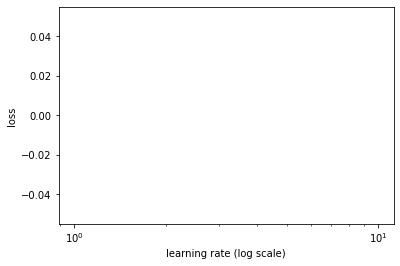

In [ ]:
learner.lr_find(show_plot=False, max_epochs=10)

In [ ]:
 learner.validate(class_names=class_name)

                   precision    recall  f1-score   support

    coloncancer 0       0.00      0.00      0.00         1
non_coloncancer 1       0.50      0.20      0.29         5

         accuracy                           0.17         6
        macro avg       0.25      0.10      0.14         6
     weighted avg       0.42      0.17      0.24         6



array([[0, 1],
       [4, 1]])

# 3. Use summary data 

In [ ]:
'''
The text that the model processes must first be tokenized and then data embedded. 
To begin with, we need to transform each text into a list as a type of data structure.
We will transform the data that are in dataFrame format to list format in this cell
'''

def summary_data_to_list(data):
  dataset  = []       # List of the text contents of all documents
  datasetlabel = []   # List of the labels 
  label_name = []     # List of label names
  for i in data['summary']:
    dataset.append(i)
  for j in data['label']:
    datasetlabel.append(j)
  for t in data['label_name']:
    label_name.append(t)
  #return dataset , datasetlabel,label_name

In [ ]:
# use our dataset to transform to list.
summary_data_to_list(all_data_summary) 

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(dataset, datasetlabel, test_size=0.25)

In [ ]:
print(f'train data size {len(train_texts)}')
print(f'test data size {len(test_texts)}')

train data size 18
test data size 6


# Use distilbert for summary data

In [ ]:
class_name =['coloncancer', 'no_coloncancer'] # the name of classes
model_name = 'distilbert-base-uncased'   # the name of the model  that we have to use

In [ ]:
transf_model = text.Transformer(model_name, maxlen=512,class_names=class_name) 

In [ ]:
# Data preprocess for training task

train_data = transf_model.preprocess_train(train_texts,train_labels) 
test_data  = transf_model.preprocess_test(test_texts,test_labels)

preprocessing train...
language: en
train sequence lengths:
	mean : 280
	95percentile : 570
	99percentile : 670


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 225
	95percentile : 356
	99percentile : 374


In [ ]:
# Download the classifier (distilBert model)
model = transf_model.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train_data,val_data=test_data,batch_size=16)

In [ ]:
learner.lr_find(show_plot=False, max_epochs=10)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
1/1 [==============================] - 43s 43s/step - loss: 0.6954 - accuracy: 0.5625
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.6935 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 35s 35s/step - loss: 0.6922 - accuracy: 0.4375
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.6737 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 35s 35s/step - loss: 0.6853 - accuracy: 0.6875
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.5289 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 35s 35s/step - loss: 0.7812 - accuracy: 0.6250
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.3280 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 35s 35s/step - loss: 24.7125 - accuracy: 0.5000


done.
Please invoke the Learner.lr_plot() method 

In [ ]:
 learner.validate(class_names=class_name)

                precision    recall  f1-score   support

   coloncancer       0.00      0.00      0.00         2
no_coloncancer       0.60      0.75      0.67         4

      accuracy                           0.50         6
     macro avg       0.30      0.38      0.33         6
  weighted avg       0.40      0.50      0.44         6



array([[0, 2],
       [1, 3]])